# Previsão de Churn

### Discente(s):

    Bruno Antonio dos Santos Bezerra
    Erick Vinicius Rebouças Cruz
    Gabriel Monteiro Silva

### Framework:
    TensorFlow/Keras

### Requerimentos:
    1. Python 3.9
    2. Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
    3. Pandas
    4. Matplotlib
    5. Sklearn
    6. Numpy
    7. Dataset: https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services

### Etapas do Projeto:
    1. Importação de bibliotecas e dados
    2. Análise dos dados
    3. Pré-processamento dos dados
    4. Otimização de hiperparâmetros com optuna - (Arquivos Separados)
    5. Modelos
    6. Análise dos melhores modelos encontrados - (AUC-ROC, KS, Matriz de confusão, Recall, Precision, F-Measure, MSE)

# 1. Importação de bibliotecas e dados

In [8]:
# === Manipulação de dados ===
import numpy as np  # Manipulação de arrays e operações numéricas.
import pandas as pd  # Manipulação e análise de dados em tabelas (DataFrames).

# === Visualização de dados ===
import matplotlib.pyplot as plt  # Criação de gráficos e visualizações básicas.
import seaborn as sns  # Visualizações estatísticas mais elaboradas e bonitas.

# === Pré-processamento ===
from sklearn.preprocessing import StandardScaler  # Padronização de variáveis numéricas.
from sklearn.preprocessing import OneHotEncoder  # Codificação de variáveis categóricas.

# === Avaliação de modelos ===
from sklearn.metrics import (  
    r2_score,  # Coeficiente de determinação (regressão).
    roc_curve,  # Curva ROC (classificação binária).
    auc,  # Área sob a curva ROC.
    accuracy_score,  # Acurácia da classificação.
    precision_score,  # Precisão (classificação binária).
    recall_score,  # Revocação (sensibilidade).
    classification_report  # Relatório completo de métricas de classificação.
)

# === Modelagem e validação cruzada ===
from sklearn.model_selection import KFold  # Validação cruzada simples.
from sklearn.model_selection import StratifiedKFold  # Validação cruzada estratificada (mantém proporção de classes).
from sklearn.ensemble import RandomForestClassifier  # Classificador baseado em florestas aleatórias.

# === Deep Learning ===
import tensorflow as tf  # Biblioteca principal para deep learning.
from tensorflow.keras.models import Sequential, Model  # Modelos sequenciais e funcionais em Keras.
from tensorflow.keras.layers import Dense, Dropout, Input  # Camadas básicas da rede neural.
from tensorflow.keras.optimizers import Adam  # Otimizador de descida do gradiente adaptativo.
from tensorflow.keras.losses import BinaryCrossentropy  # Função de perda para classificações binárias.
from tensorflow.keras.callbacks import EarlyStopping  # Interrompe o treinamento se não houver melhora.
from tensorflow.keras import layers, optimizers, losses, callbacks, metrics, backend  # Acesso completo às submódulos do Keras.

# === Otimização de hiperparâmetros ===
import optuna  # Biblioteca para busca e otimização de hiperparâmetros.


In [9]:
df_source = pd.read_csv('data/customer_churn_telecom_services.csv')
print(df_source.shape)
df_source.head()

(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1936.30,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,107.70,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1903.50,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,141.40,Yes


In [14]:
df = df_source.copy()
df['Churn'].replace({'Yes': 1, 'No': 0}, inplace=True)
data_positive = df[df['Churn'] == 1]
data_negative = df[df['Churn'] == 0]
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1936.30,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,107.70,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1903.50,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,141.40,1


# 2. Análise dos dados

Resumo estatístico para números:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.581350,0.265370
std,0.368612,24.559481,30.090047,2264.729447,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,394.000000,0.000000
50%,0.000000,29.000000,70.350000,1393.600000,0.000000
75%,0.000000,55.000000,89.850000,3786.100000,1.000000
max,1.000000,72.000000,118.750000,8550.000000,1.000000


Resumo estatístico para literais:


,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


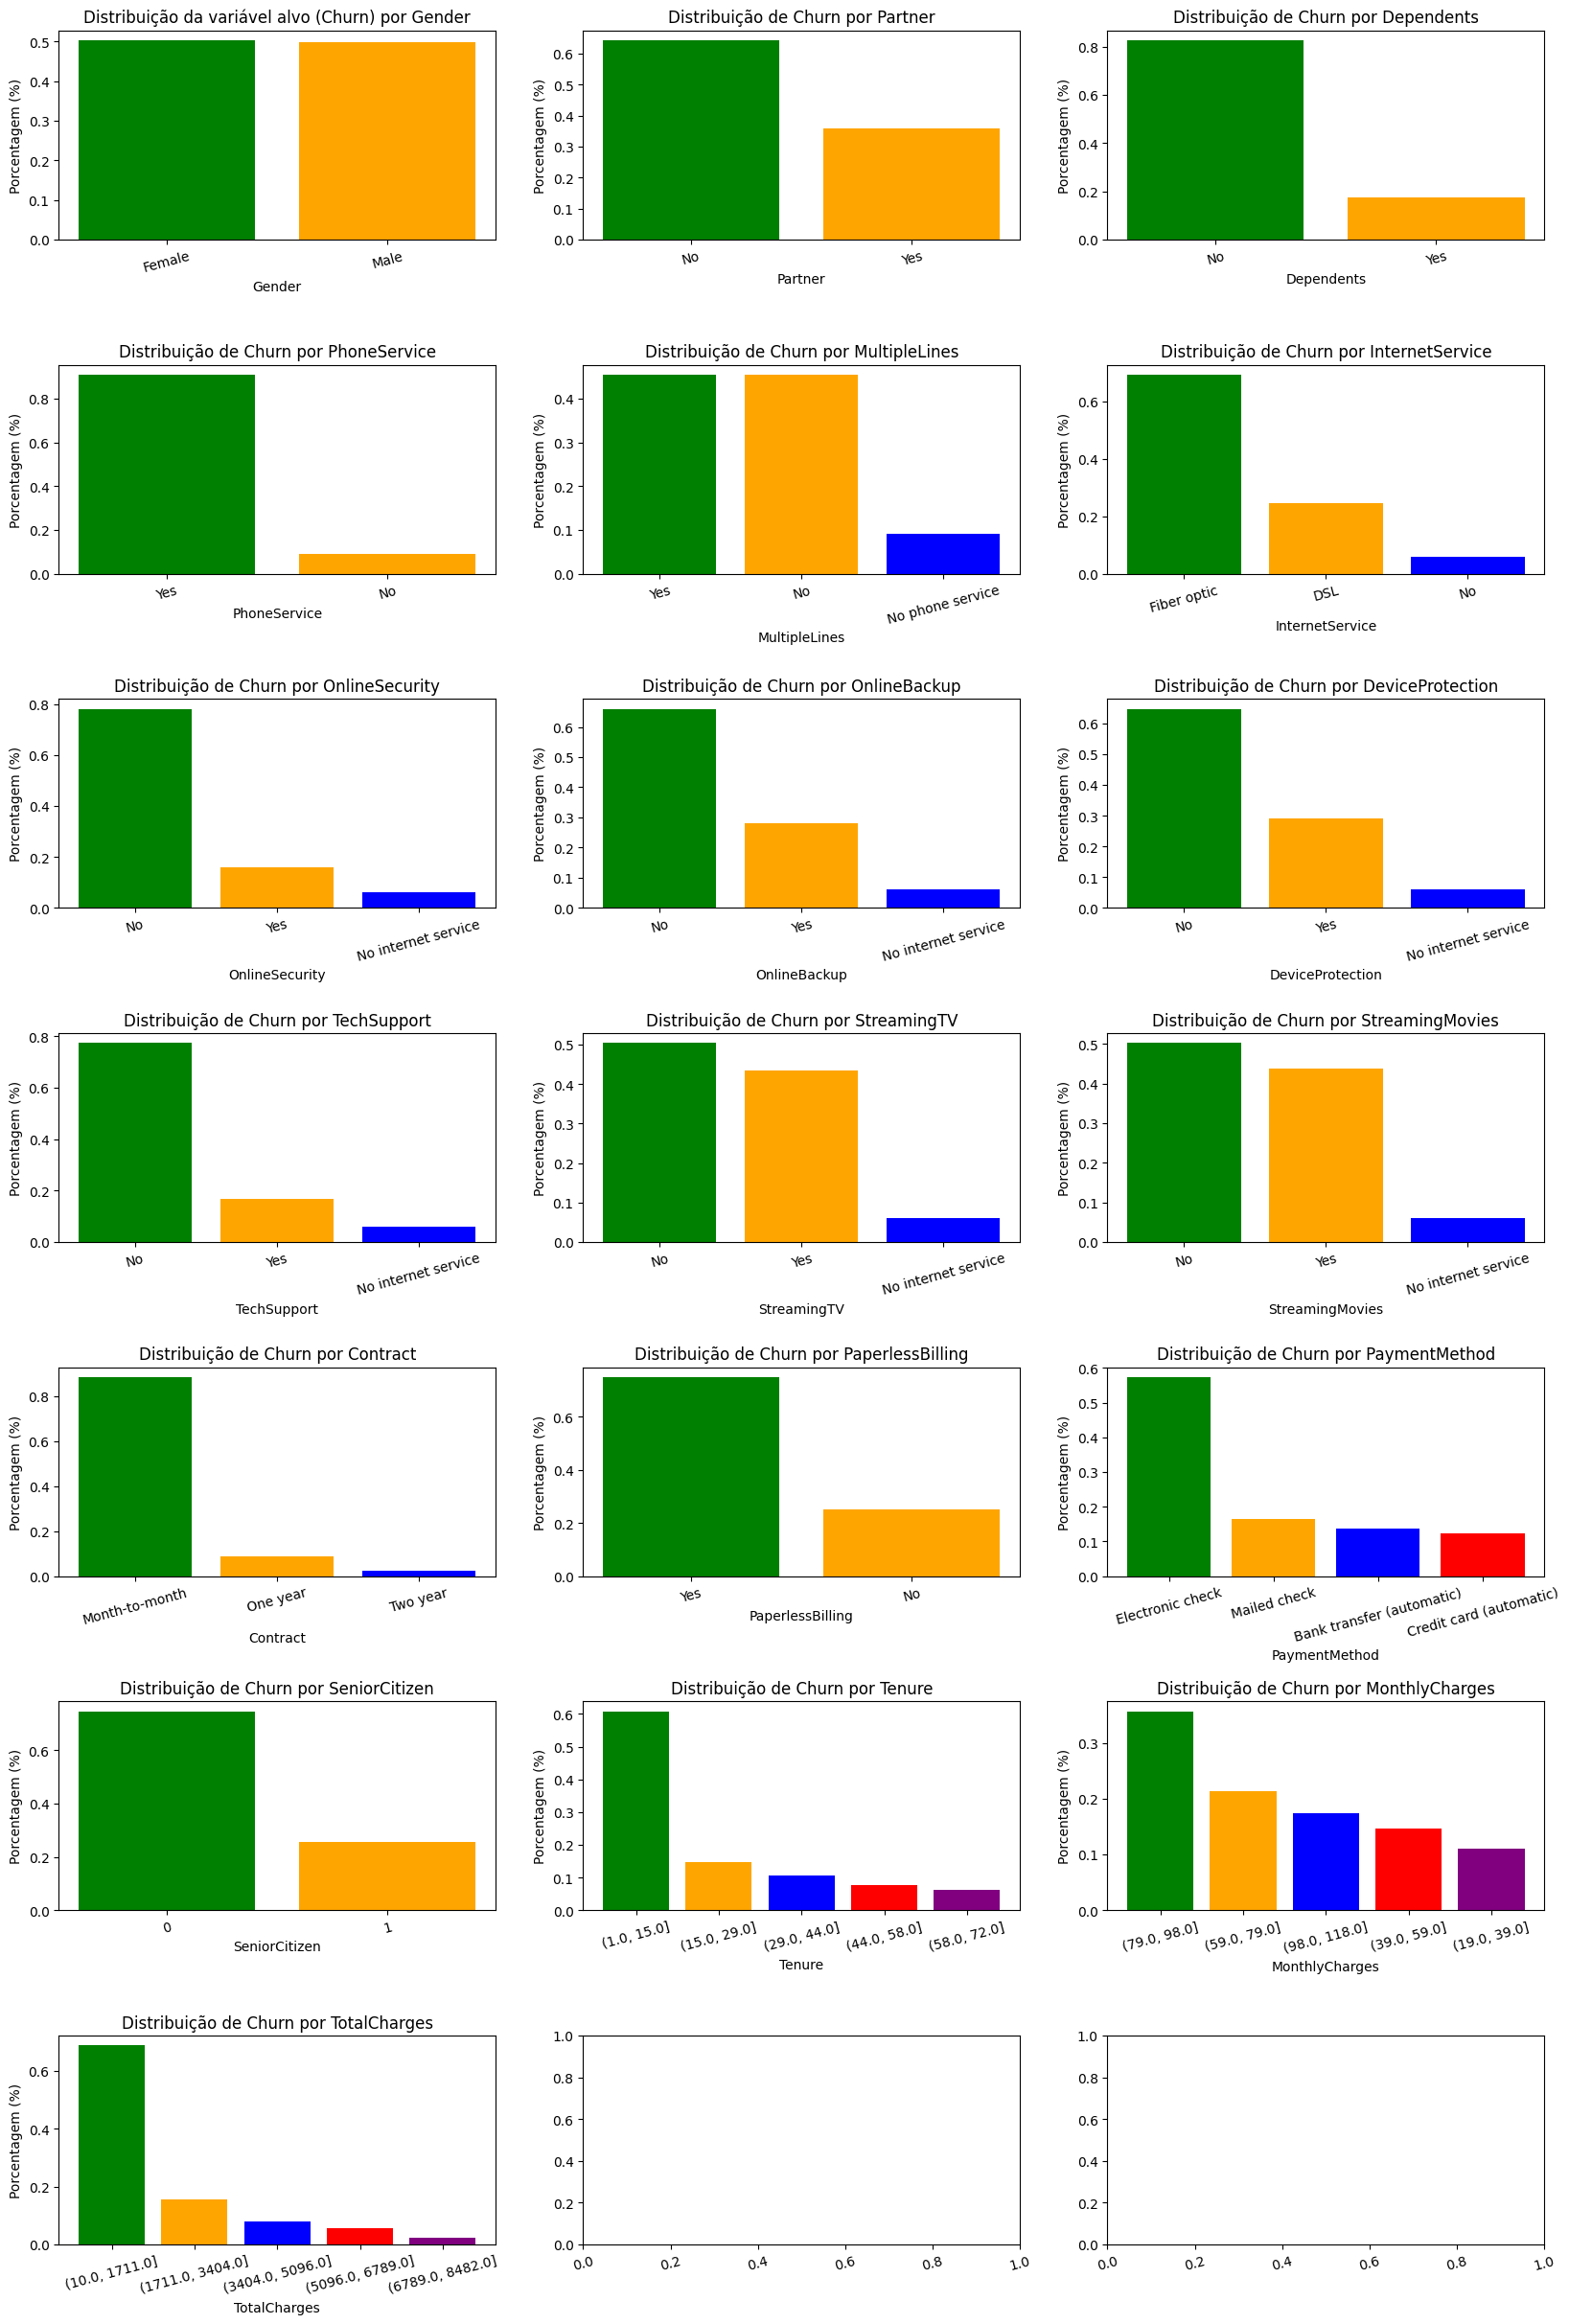

In [ ]:
eda_df = df

#  Resumo estatístico das variáveis
print("Resumo estatístico para números:")
display(pd.DataFrame(eda_df.select_dtypes(include=['number']).describe()))
print("Resumo estatístico para literais:")
display(pd.DataFrame(eda_df.select_dtypes(exclude=['number']).describe()))

fig, axes = plt.subplots(7, 3, figsize=(20, 30))

data = eda_df[eda_df["Churn"] == 1]["gender"].value_counts(normalize=True)
axes[0, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[0, 0].set_title("Distribuição da variável alvo (Churn) por Gender")
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["Partner"].value_counts(normalize=True)
axes[0, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[0, 1].set_title("Distribuição de Churn por Partner")
axes[0, 1].set_xlabel("Partner")
axes[0, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["Dependents"].value_counts(normalize=True)
axes[0, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[0, 2].set_title("Distribuição de Churn por Dependents")
axes[0, 2].set_xlabel("Dependents")
axes[0, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["PhoneService"].value_counts(normalize=True)
axes[1, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[1, 0].set_title("Distribuição de Churn por PhoneService")
axes[1, 0].set_xlabel("PhoneService")
axes[1, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["MultipleLines"].value_counts(normalize=True)
axes[1, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[1, 1].set_title("Distribuição de Churn por MultipleLines")
axes[1, 1].set_xlabel("MultipleLines")
axes[1, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["InternetService"].value_counts(normalize=True)
axes[1, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[1, 2].set_title("Distribuição de Churn por InternetService")
axes[1, 2].set_xlabel("InternetService")
axes[1, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["OnlineSecurity"].value_counts(normalize=True)
axes[2, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[2, 0].set_title("Distribuição de Churn por OnlineSecurity")
axes[2, 0].set_xlabel("OnlineSecurity")
axes[2, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["OnlineBackup"].value_counts(normalize=True)
axes[2, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[2, 1].set_title("Distribuição de Churn por OnlineBackup")
axes[2, 1].set_xlabel("OnlineBackup")
axes[2, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["DeviceProtection"].value_counts(normalize=True)
axes[2, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[2, 2].set_title("Distribuição de Churn por DeviceProtection")
axes[2, 2].set_xlabel("DeviceProtection")
axes[2, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["TechSupport"].value_counts(normalize=True)
axes[3, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[3, 0].set_title("Distribuição de Churn por TechSupport")
axes[3, 0].set_xlabel("TechSupport")
axes[3, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["StreamingTV"].value_counts(normalize=True)
axes[3, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[3, 1].set_title("Distribuição de Churn por StreamingTV")
axes[3, 1].set_xlabel("StreamingTV")
axes[3, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["StreamingMovies"].value_counts(normalize=True)
axes[3, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[3, 2].set_title("Distribuição de Churn por StreamingMovies")
axes[3, 2].set_xlabel("StreamingMovies")
axes[3, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["Contract"].value_counts(normalize=True)
axes[4, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[4, 0].set_title("Distribuição de Churn por Contract")
axes[4, 0].set_xlabel("Contract")
axes[4, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["PaperlessBilling"].value_counts(normalize=True)
axes[4, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[4, 1].set_title("Distribuição de Churn por PaperlessBilling")
axes[4, 1].set_xlabel("PaperlessBilling")
axes[4, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["PaymentMethod"].value_counts(normalize=True)
axes[4, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[4, 2].set_title("Distribuição de Churn por PaymentMethod")
axes[4, 2].set_xlabel("PaymentMethod")
axes[4, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == 1]["SeniorCitizen"].value_counts(normalize=True)
axes[5, 0].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[5, 0].set_title("Distribuição de Churn por SeniorCitizen")
axes[5, 0].set_xlabel("SeniorCitizen")
axes[5, 0].set_ylabel("Porcentagem (%)")

data = pd.cut(eda_df[eda_df["Churn"] == 1]["tenure"], bins=5, precision=0).value_counts(normalize=True)
axes[5, 1].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[5, 1].set_title("Distribuição de Churn por Tenure")
axes[5, 1].set_xlabel("Tenure")
axes[5, 1].set_ylabel("Porcentagem (%)")

data = pd.cut(eda_df[eda_df["Churn"] == 1]["MonthlyCharges"], bins=5, precision=0).value_counts(normalize=True)
axes[5, 2].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[5, 2].set_title("Distribuição de Churn por MonthlyCharges")
axes[5, 2].set_xlabel("MonthlyCharges")
axes[5, 2].set_ylabel("Porcentagem (%)")

data = pd.cut(eda_df[eda_df["Churn"] == 1]["TotalCharges"], bins=5, precision=0).value_counts(normalize=True)
axes[6, 0].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[6, 0].set_title("Distribuição de Churn por TotalCharges")
axes[6, 0].set_xlabel("TotalCharges")
axes[6, 0].set_ylabel("Porcentagem (%)")

# eda_df["tenure_category"] = pd.cut(eda_df["tenure"], bins=[0, 12, 24, 60, 120], labels=["0-1 ano", "1-2 anos", "2-5 anos", "5+ anos"])
# plt.figure(figsize=(8, 5))
# sns.countplot(x=eda_df["tenure_category"], hue=eda_df["Churn"])
# plt.title("Distribuição do Tempo de Cliente vs Churn")
# plt.xlabel("Tempo como Cliente")
# plt.ylabel("Contagem")
# plt.legend(title="Churn", labels=["Não", "Sim"])
# plt.show()

# eda_df["MonthlyCharges_category"] = pd.cut(eda_df["MonthlyCharges"], bins=5, labels=["Muito Baixo", "Baixo", "Médio", "Alto", "Muito Alto"])
# churn_counts = eda_df.groupby("MonthlyCharges_category", observed=True)["Churn"].value_counts(normalize=True).unstack()
# churn_counts.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="coolwarm")
# plt.title("Porcentagem Acumulativa de Churn por Faixa de Pagamento")
# plt.xlabel("Faixa de Pagamento Mensal")
# plt.ylabel("Proporção de Churn")
# plt.legend(title="Churn", labels=["Não", "Sim"])
# plt.grid(axis="y", linestyle="--", alpha=0.7)

fig.subplots_adjust(hspace=0.6)
for ax in fig.get_axes():  # Percorre todos os subgráficos
    ax.tick_params(axis="x", rotation=15)
plt.show()

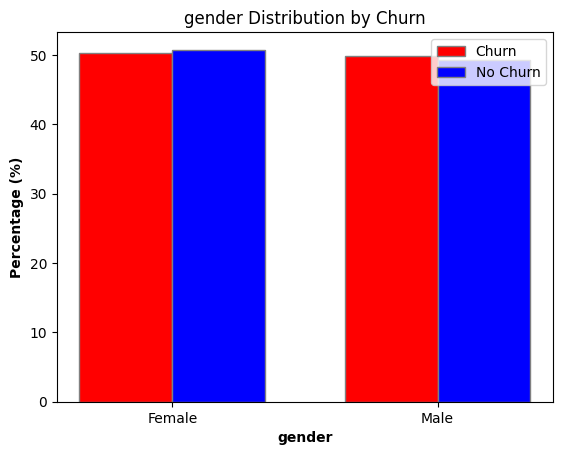

In [18]:
# Contagem de valores de gênero para churn positivo e negativo
positive_gender_counts = data_positive['gender'].value_counts()
negative_gender_counts = data_negative['gender'].value_counts()

# Calculando as porcentagens
total_positive = positive_gender_counts.sum()
total_negative = negative_gender_counts.sum()

positive_gender_percent = (positive_gender_counts / total_positive) * 100
negative_gender_percent = (negative_gender_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_gender_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_gender_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_gender_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('gender', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_gender_percent))], positive_gender_percent.index)
plt.title('gender Distribution by Churn')
plt.legend()
plt.show()

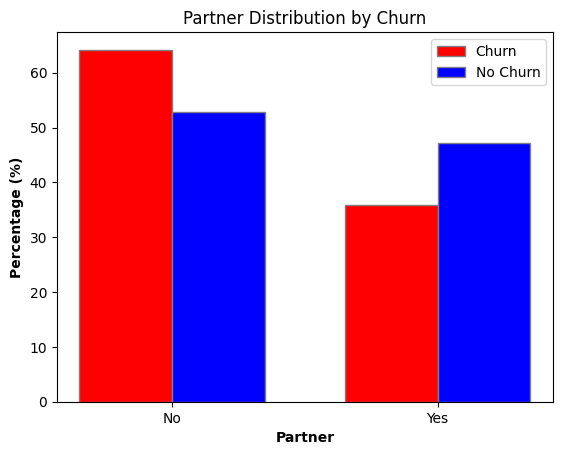

In [ ]:
# Contagem de valores de gênero para churn positivo e negativo
positive_partner_counts = data_positive['Partner'].value_counts()
negative_partner_counts = data_negative['Partner'].value_counts()

# Calculando as porcentagens
total_positive = positive_partner_counts.sum()
total_negative = negative_partner_counts.sum()

positive_partner_percent = (positive_partner_counts / total_positive) * 100
negative_partner_percent = (negative_partner_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_partner_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_partner_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_partner_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('Partner', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_partner_percent))], positive_partner_percent.index)
plt.title('Partner Distribution by Churn')
plt.legend()
plt.show()

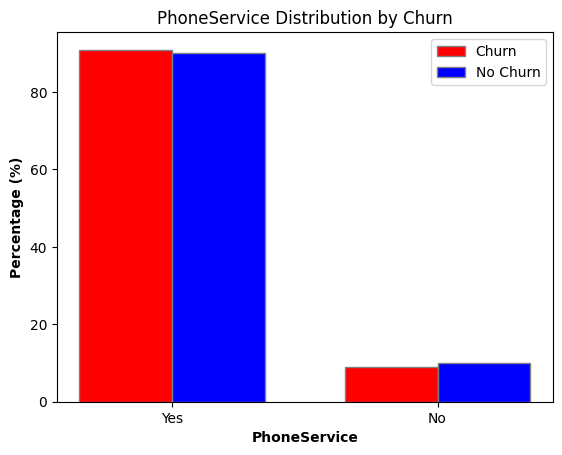

In [6]:
# Contagem de valores de gênero para churn positivo e negativo
positive_PhoneService_counts = data_positive['PhoneService'].value_counts()
negative_PhoneService_counts = data_negative['PhoneService'].value_counts()

# Calculando as porcentagens
total_positive = positive_PhoneService_counts.sum()
total_negative = negative_PhoneService_counts.sum()

positive_PhoneService_percent = (positive_PhoneService_counts / total_positive) * 100
negative_PhoneService_percent = (negative_PhoneService_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_PhoneService_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_PhoneService_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_PhoneService_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('PhoneService', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_PhoneService_percent))], positive_PhoneService_percent.index)
plt.title('PhoneService Distribution by Churn')
plt.legend()
plt.show()

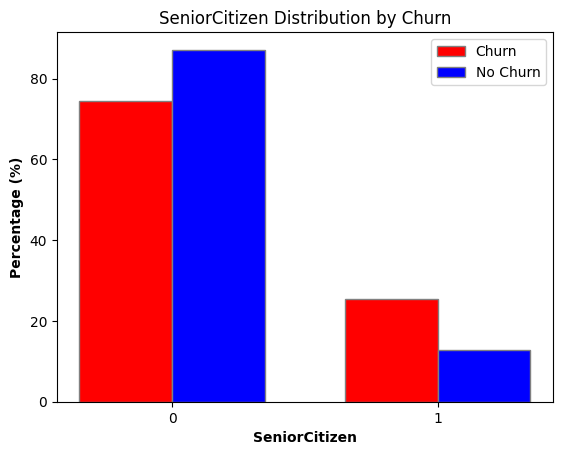

In [7]:
# Contagem de valores de gênero para churn positivo e negativo
positive_SeniorCitizen_counts = data_positive['SeniorCitizen'].value_counts()
negative_SeniorCitizen_counts = data_negative['SeniorCitizen'].value_counts()

# Calculando as porcentagens
total_positive = positive_SeniorCitizen_counts.sum()
total_negative = negative_SeniorCitizen_counts.sum()

positive_SeniorCitizen_percent = (positive_SeniorCitizen_counts / total_positive) * 100
negative_SeniorCitizen_percent = (negative_SeniorCitizen_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_SeniorCitizen_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_SeniorCitizen_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_SeniorCitizen_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('SeniorCitizen', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_SeniorCitizen_percent))], positive_SeniorCitizen_percent.index)
plt.title('SeniorCitizen Distribution by Churn')
plt.legend()
plt.show()

# 3. Pré-processamento dos dados

In [9]:
# Corrige a remoção de duplicatas (atribui o resultado de volta ao DataFrame)
df = df.drop_duplicates(ignore_index=True)
df = df.fillna(0)
# df.dropna(ignore_index=True)  # opção alternativa, se necessário
df = pd.get_dummies(df, drop_first=True)
data = df
df_data = df.drop(columns='Churn')
df_target = df['Churn']

In [ ]:
def k_fold_train_val_test(data, k=5, test_size=0.2, random_state=42):

    # Garante reprodutibilidade
    np.random.seed(random_state)
    
    # Número total de amostras
    n_samples = len(data)
    
    # Separação inicial entre conjunto de treinamento+validação e conjunto de teste
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Número de amostras para teste
    n_test = int(n_samples * test_size)
    
    # Índices para teste (fixos para todos os folds)
    test_indices = indices[:n_test]
    
    # Índices para treinamento + validação
    train_val_indices = indices[n_test:]
    
    # Aplicar k-fold nos índices de treinamento + validação
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Lista para armazenar os índices de cada fold
    fold_indices = []
    
    # Iterar sobre os splits do k-fold
    for train_idx, val_idx in kf.split(train_val_indices):
        # Mapear os índices do split para os índices originais do dataset
        train_indices = train_val_indices[train_idx]
        val_indices = train_val_indices[val_idx]
        
        # Armazenar os índices deste fold
        fold_indices.append((train_indices, val_indices, test_indices))
    
    return fold_indices

folds = k_fold_train_val_test(data, k=5, test_size=0.25, random_state=42)

# Troque o valor de fold_order para 0, 1, 2, 3 ou 4 para escolher um dos folds
fold_order = 0 #
df_treino = data.iloc[folds[fold_order][0]]
df_test = data.iloc[folds[fold_order][1]]
df_validacao = data.iloc[folds[fold_order][2]]

In [ ]:
# VERIFICAR 001
# # Plotando a quantidade de dados de treino e teste.
# plt.bar(['Treino', 'Teste', 'Validação'], [df_treino.shape[0], df_test.shape[0], df_validacao.shape[0]])
# plt.show()

# plt.bar(df_treino['Churn'].value_counts().index, df_treino['Churn'].value_counts(), color=['blue', 'red'])
# plt.xticks([0, 1])
# plt.show()

# plt.bar(df_test['Churn'].value_counts().index, df_test['Churn'].value_counts(), color=['blue', 'red'])
# plt.xticks([0, 1])
# plt.show()

# plt.bar(df_validacao['Churn'].value_counts().index, df_validacao['Churn'].value_counts(), color=['blue', 'red'])
# plt.xticks([0, 1])
# plt.show()

# # Separando os dados de entrada e saída.
# X_treino = df_treino.drop(columns=['Churn'])
# y_treino = df_treino['Churn']

# X_test = df_test.drop(columns=['Churn'])
# y_test = df_test['Churn']

# X_val = df_validacao.drop(columns=['Churn'])
# y_val = df_validacao['Churn']

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_treino)
# y_train = y_treino

# X_val = scaler.transform(X_val)
# y_val = y_val

# X_test = scaler.transform(X_test)
# y_test = y_test

# 4. Otimização de Hiperparâmetros com Optuna

In [ ]:
# Arquivos das otimizações gerados separadamente

# 5. Modelos

## 5.1 MLP

### Melhor modelo encontrado com base nos testes

In [16]:
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])



early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
132/132 [==============================] - 2s 5ms/step - loss: 0.5163 - accuracy: 0.7351 - precision: 0.5141 - recall: 0.4009 - val_loss: 0.4174 - val_accuracy: 0.8027 - val_precision: 0.6534 - val_recall: 0.4776
Epoch 2/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4620 - accuracy: 0.7809 - precision: 0.6241 - recall: 0.4807 - val_loss: 0.4101 - val_accuracy: 0.8062 - val_precision: 0.6699 - val_recall: 0.4686
Epoch 3/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4489 - accuracy: 0.7864 - precision: 0.6377 - recall: 0.4895 - val_loss: 0.4056 - val_accuracy: 0.8033 - val_precision: 0.6407 - val_recall: 0.5157
Epoch 4/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4385 - accuracy: 0.7938 - precision: 0.6488 - recall: 0.5202 - val_loss: 0.4054 - val_accuracy: 0.8090 - val_precision: 0.6537 - val_recall: 0.5291
Epoch 5/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4389 - accuracy: 0.7916

### Valores e graficos de metricas estatistica do modelo


Resultados no Teste:
- Acurácia: 0.8025
- Precisão: 0.6413
- Recall: 0.5277


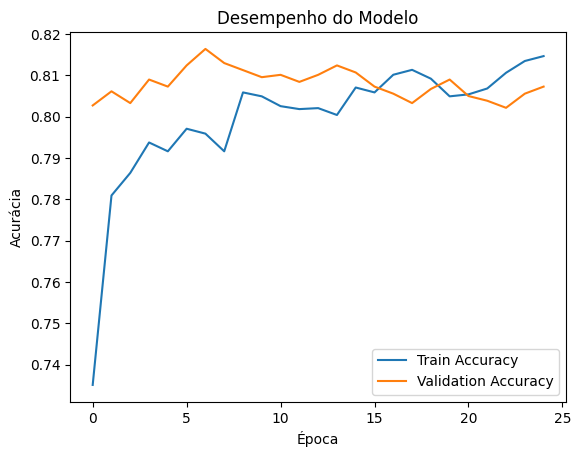

33/33 [==============================] - 0s 1ms/step


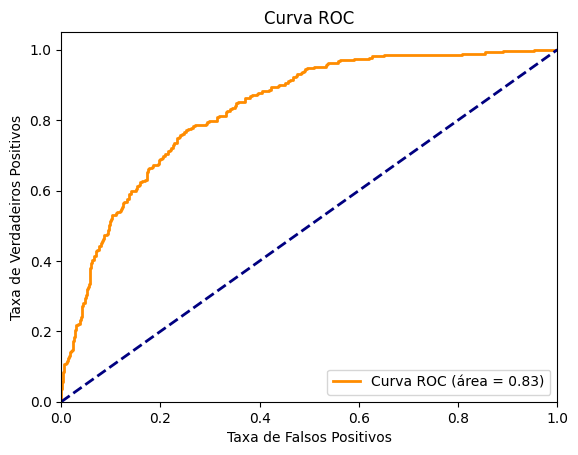

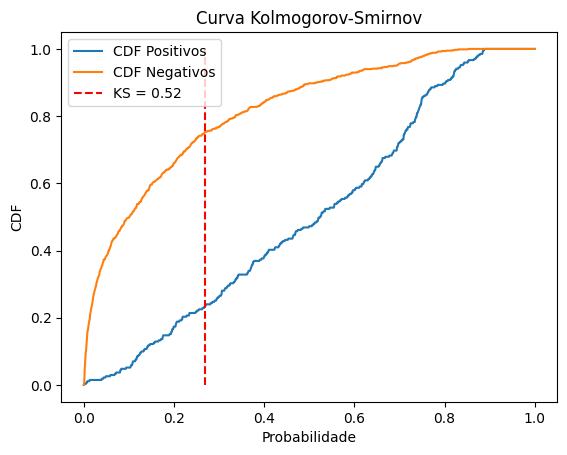

In [17]:
# Avaliação do modelo no conjunto de teste
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f'''
Resultados no Teste:
- Acurácia: {test_results[1]:.4f}
- Precisão: {test_results[2]:.4f}
- Recall: {test_results[3]:.4f}''')

# 6. Visualização do Treinamento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Desempenho do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()
plt.show()

# Plotando a curva ROC
y_pred_MLP = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_MLP)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Plotando a curva Kolmogorov-Smirnov (KS)
# Separando as previsões de probabilidades em positivos e negativos
preds_positive = y_pred_MLP[y_test == 1]
preds_negative = y_pred_MLP[y_test == 0]

# Definindo uma gama de limiares para calcular as CDFs
ks_thresholds = np.linspace(0, 1, 1000)
cdf_positive = [np.mean(preds_positive <= t) for t in ks_thresholds]
cdf_negative = [np.mean(preds_negative <= t) for t in ks_thresholds]

# Calculando a estatística KS como a máxima diferença absoluta entre as CDFs
ks_values = np.abs(np.array(cdf_positive) - np.array(cdf_negative))
ks_statistic = np.max(ks_values)
ks_best_threshold = ks_thresholds[np.argmax(ks_values)]

plt.figure()
plt.plot(ks_thresholds, cdf_positive, label='CDF Positivos')
plt.plot(ks_thresholds, cdf_negative, label='CDF Negativos')
plt.vlines(ks_best_threshold, min(np.min(cdf_positive), np.min(cdf_negative)),
           max(np.max(cdf_positive), np.max(cdf_negative)),
           colors='red', linestyles='--', label=f'KS = {ks_statistic:.2f}')
plt.xlabel('Probabilidade')
plt.ylabel('CDF')
plt.title('Curva Kolmogorov-Smirnov')
plt.legend()
plt.show()


### Dados gerados

In [18]:
metrics = pd.read_excel('MLP/optuna_results_MLP.xlsx')
metrics.head()


,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_learning_rate,params_n_layers,params_units_0,params_units_1,params_units_2,state,val_accuracy,val_precision,val_recall,val_f1_score,val_auc_roc,param_observado
0,0,0.441566,2025-02-23 21:53:42.233,2025-02-23 21:53:53.133,0.000126,128,0.1,0.000117,3,128,64.0,16.0,COMPLETE,0.789892,0.637647,0.556468,0.594298,0.833463,Minimaze Loss
1,1,0.438416,2025-02-23 21:53:53.141,2025-02-23 21:54:08.080,0.000173,32,0.2,0.000166,2,112,80.0,NaN,COMPLETE,0.792731,0.656410,0.525667,0.583808,0.833727,Minimaze Loss
2,2,0.446357,2025-02-23 21:54:08.090,2025-02-23 21:54:15.814,0.000089,128,0.1,0.000195,3,96,128.0,32.0,COMPLETE,0.789892,0.645161,0.533881,0.584270,0.829385,Minimaze Loss
3,3,0.445582,2025-02-23 21:54:15.822,2025-02-23 21:54:26.482,0.000123,128,0.1,0.000174,3,80,128.0,112.0,COMPLETE,0.787053,0.634615,0.542094,0.584718,0.830151,Minimaze Loss
4,4,0.446058,2025-02-23 21:54:26.490,2025-02-23 21:54:37.020,0.000122,112,0.0,0.000162,3,48,48.0,16.0,COMPLETE,0.793867,0.665775,0.511294,0.578397,0.828616,Minimaze Loss


## 5.2 Random Forest


### Melhor modelo encontrado com base nos testes

In [19]:


# Create the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=8,       # Maximum depth of each tree
    min_samples_split=5, # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples required at a leaf
    random_state=42,     # For reproducibility
    n_jobs=-1            # Use all available cores
)

# Train the model on training data
rf_model.fit(X_train, y_train)

# For tracking metrics during training (to simulate history)
# We'll use subsets of trees to simulate "epochs"
train_accuracies = []
val_accuracies = []

# Simulate "epochs" with different numbers of trees
tree_counts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for n_trees in tree_counts:
    # Create a temporary model with subset of trees
    temp_model = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    # Train on training data
    temp_model.fit(X_train, y_train)
    
    # Calculate accuracies
    train_pred = temp_model.predict(X_train)
    val_pred = temp_model.predict(X_val)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)




    

### Calculo das features mais importantes da Random Forest

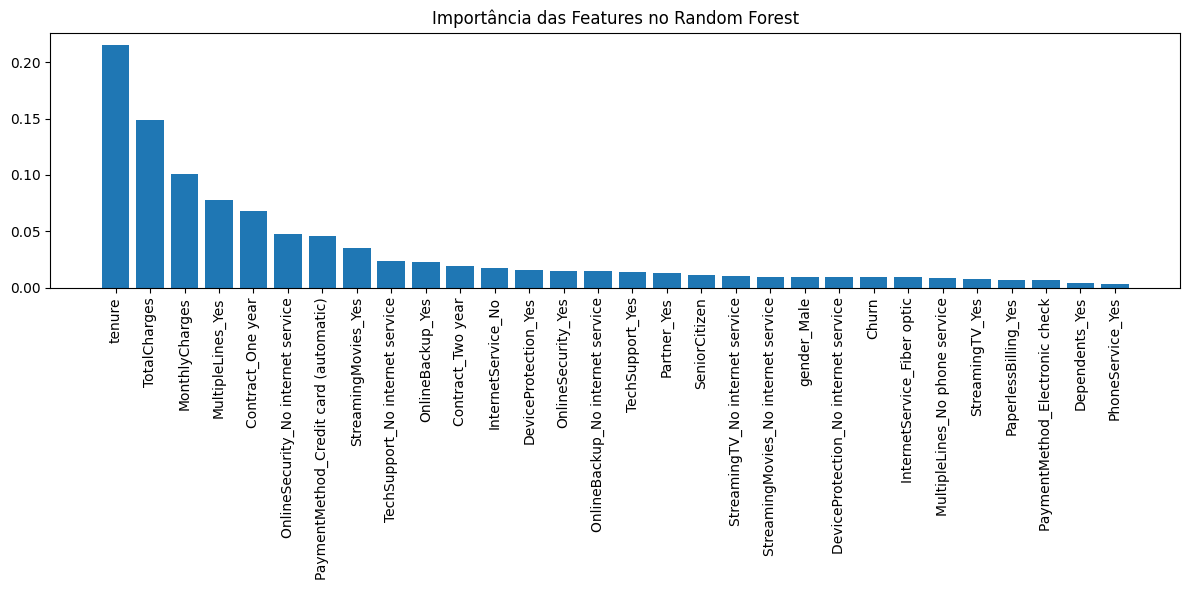

In [20]:

# Additional feature importance visualization (unique to Random Forest)
if hasattr(X_train, 'columns'):  # If X_train is a pandas DataFrame
    feature_names = X_train.columns
else:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
feature_names = df_treino.columns
# Get and sort feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title('Importância das Features no Random Forest')
plt.tight_layout()
plt.show()

### Valores e graficos de metricas estatistica do modelo


Resultados no Teste:
- Acurácia: 0.8025
- Precisão: 0.6413
- Recall: 0.5277


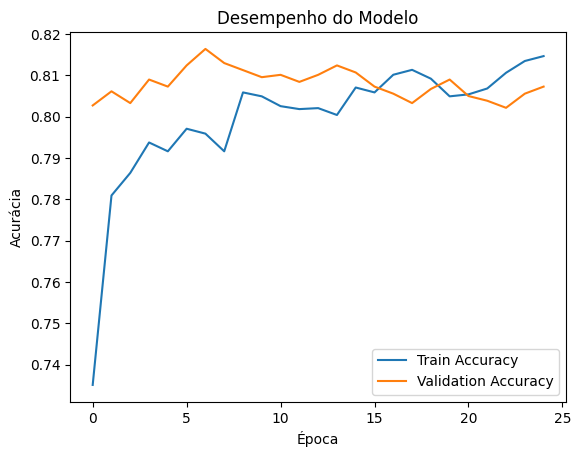

33/33 [==============================] - 0s 2ms/step


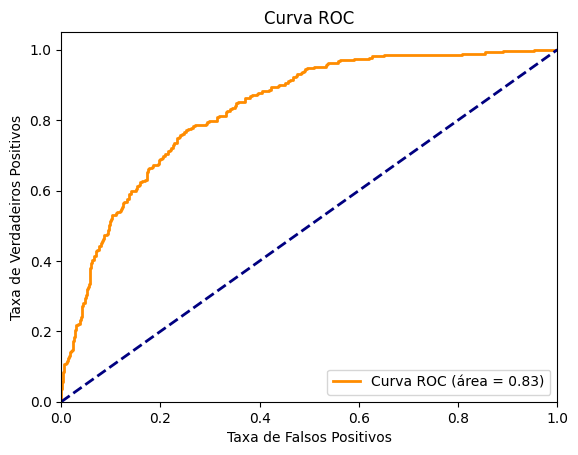

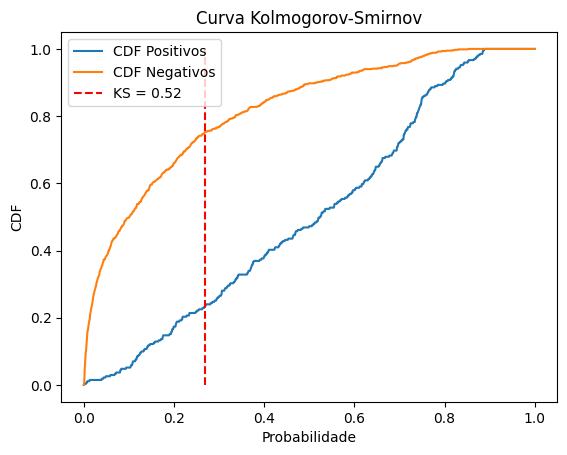

In [21]:
# Avaliação do modelo no conjunto de teste
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f'''
Resultados no Teste:
- Acurácia: {test_results[1]:.4f}
- Precisão: {test_results[2]:.4f}
- Recall: {test_results[3]:.4f}''')

# 6. Visualização do Treinamento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Desempenho do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()
plt.show()

# Plotando a curva ROC
y_pred_rf = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Plotando a curva Kolmogorov-Smirnov (KS)
# Separando as previsões de probabilidades em positivos e negativos
preds_positive = y_pred_rf[y_test == 1]
preds_negative = y_pred_rf[y_test == 0]

# Definindo uma gama de limiares para calcular as CDFs
ks_thresholds = np.linspace(0, 1, 1000)
cdf_positive = [np.mean(preds_positive <= t) for t in ks_thresholds]
cdf_negative = [np.mean(preds_negative <= t) for t in ks_thresholds]

# Calculando a estatística KS como a máxima diferença absoluta entre as CDFs
ks_values = np.abs(np.array(cdf_positive) - np.array(cdf_negative))
ks_statistic = np.max(ks_values)
ks_best_threshold = ks_thresholds[np.argmax(ks_values)]

plt.figure()
plt.plot(ks_thresholds, cdf_positive, label='CDF Positivos')
plt.plot(ks_thresholds, cdf_negative, label='CDF Negativos')
plt.vlines(ks_best_threshold, min(np.min(cdf_positive), np.min(cdf_negative)),
           max(np.max(cdf_positive), np.max(cdf_negative)),
           colors='red', linestyles='--', label=f'KS = {ks_statistic:.2f}')
plt.xlabel('Probabilidade')
plt.ylabel('CDF')
plt.title('Curva Kolmogorov-Smirnov')
plt.legend()
plt.show()


In [22]:
test = pd.read_excel('Gradient_Boost\optuna_results_GB.xlsx')
test
test.sort_values(by='value', ascending=False, inplace=True)
test

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_subsample,user_attrs_val_accuracy,user_attrs_val_auc_roc,user_attrs_val_f1_score,user_attrs_val_ks,user_attrs_val_precision,user_attrs_val_recall,state,param_observado
491,491,0.556687,2025-03-30 20:07:14.147,2025-03-30 20:07:19.277,0.000059,0.038820,1,sqrt,4,15,484,0.334671,0.805300,0.849404,0.581625,0.556687,0.674235,0.511558,COMPLETE,Maximize KS
440,440,0.556432,2025-03-30 20:01:58.075,2025-03-30 20:02:03.138,0.000059,0.041498,1,sqrt,5,8,471,0.339572,0.804160,0.849423,0.579390,0.556432,0.671152,0.509941,COMPLETE,Maximize KS
188,188,0.556017,2025-03-30 19:45:21.489,2025-03-30 19:45:24.723,0.000037,0.100033,1,log2,3,14,339,0.310271,0.806156,0.850250,0.591483,0.556017,0.668498,0.530935,COMPLETE,Maximize KS
388,388,0.555947,2025-03-30 19:58:04.525,2025-03-30 19:58:08.347,0.000044,0.048820,1,sqrt,5,12,446,0.338625,0.804160,0.849669,0.581954,0.555947,0.668791,0.515326,COMPLETE,Maximize KS
144,144,0.555876,2025-03-30 19:42:12.685,2025-03-30 19:42:16.393,0.000043,0.059567,1,log2,5,12,389,0.315774,0.804873,0.849356,0.584485,0.555876,0.669320,0.519094,COMPLETE,Maximize KS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,226,0.482162,2025-03-30 19:48:02.300,2025-03-30 19:48:18.384,0.000186,0.097343,8,log2,2,11,325,0.314278,0.775085,0.811929,0.540926,0.482162,0.588068,0.501325,COMPLETE,Maximize KS
344,344,0.477251,2025-03-30 19:55:13.361,2025-03-30 19:55:24.507,0.000129,0.104624,6,log2,5,4,441,0.342797,0.781212,0.810223,0.551931,0.477251,0.602980,0.509401,COMPLETE,Maximize KS
95,95,0.474254,2025-03-30 19:38:23.706,2025-03-30 19:38:42.270,0.000215,0.140247,9,log2,5,12,335,0.332319,0.768099,0.804499,0.525312,0.474254,0.572272,0.486233,COMPLETE,Maximize KS
9,9,0.471167,2025-03-30 19:30:42.414,2025-03-30 19:31:09.364,0.000312,0.149569,6,NaN,8,14,382,0.765713,0.774514,0.806491,0.532183,0.471167,0.590549,0.484642,COMPLETE,Maximize KS


## 5.3 Gradient Boost

### Melhor modelo encontrado com base nos dados gerados

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold as SKFold




kf = SKFold(n_splits=5, shuffle=True, random_state=50)



model = GradientBoostingClassifier(
        n_estimators=484,
        learning_rate=0.009436,
        max_depth=1,
        min_samples_split=15,
        min_samples_leaf=4,
        subsample=0.334671,
        max_features='sqrt',
        random_state=50
    )
    
    # Inicializa listas para armazenar as métricas de cada fold
train_accuracies = []
val_accuracies = []
train_ks_values = []
val_ks_values = []
# Variáveis para guardar os dados do fold com maior KS na validação
max_val_ks = -1.0
best_y_val_for_ks_plot = None
best_y_proba_for_ks_plot = None
best_fold_num_for_ks_plot = 0
    
for train_index, val_index in kf.split(df_data, df_target):
    X_train, X_val = df_data.iloc[train_index], df_data.iloc[val_index]
    y_train, y_val = df_target.iloc[train_index], df_target.iloc[val_index]
    
    model.fit(X_train, y_train)
    
    # Previsões e probabilidades
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Cálculo das acurácias
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    # Cálculo do KS (diferença máxima entre TPR e FPR)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    train_ks = max(np.abs(tpr_train - fpr_train))
    val_ks = max(np.abs(tpr_val - fpr_val))
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_ks_values.append(train_ks)
    val_ks_values.append(val_ks)

    roc_auc = auc(fpr, tpr)



    # --- Salva os dados se este fold tiver o maior KS de validação até agora ---
    if val_ks > max_val_ks:
        max_val_ks = val_ks
        # Salva cópias dos arrays para usar depois do loop
        best_y_val_for_ks_plot = y_val.copy()
        best_y_proba_for_ks_plot = y_val_proba.copy()
        best_fold_num_for_ks_plot = len(train_accuracies) - 1


# Cálculo das métricas médias nos folds
mean_train_acc = np.mean(train_accuracies)
mean_val_acc = np.mean(val_accuracies)
mean_train_ks = np.mean(train_ks_values)
mean_val_ks = np.mean(val_ks_values)

mean_train_acc, mean_val_acc, mean_train_ks, mean_val_ks

(0.7843143189513093,
 0.7827811994241074,
 0.5368041849123366,
 0.5379730295128389)

### Valores e graficos de metricas estatistica do modelo

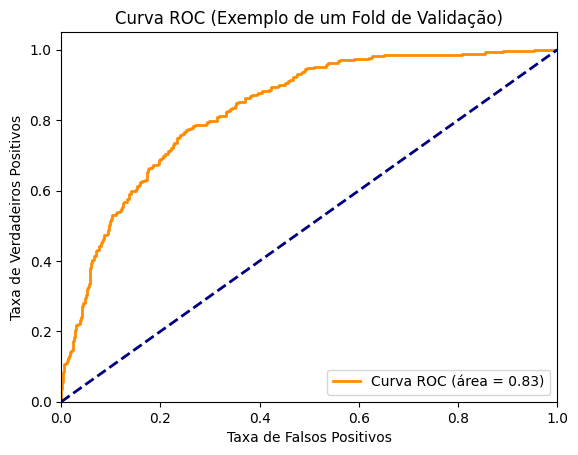

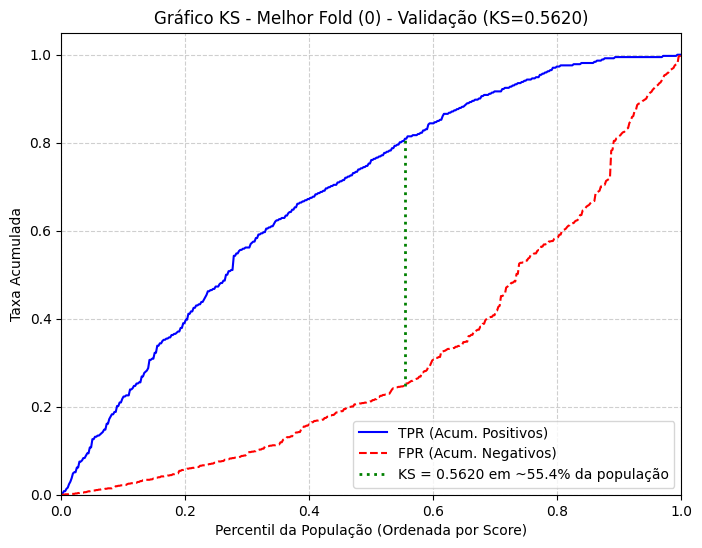

In [24]:

def plot_ks_statistic(y_true, y_proba, title='Gráfico KS'):

    # Garante que os inputs sejam arrays numpy
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    # Calcula FPR, TPR (necessários para o KS)
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    # Calcula o valor KS (diferença máxima entre TPR e FPR)
    ks_value = np.max(tpr - fpr)
    ks_index = np.argmax(tpr - fpr)

    # Cria o eixo X representando o percentil da população (aproximado)
    population_percentile = np.linspace(0, 1, len(tpr))
    x_ks_point = population_percentile[ks_index]


    plt.figure(figsize=(8, 6))


    plt.plot(population_percentile, tpr, label='TPR (Acum. Positivos)', color='blue')
    plt.plot(population_percentile, fpr, label='FPR (Acum. Negativos)', color='red', linestyle='--')


    plt.plot([x_ks_point, x_ks_point], [fpr[ks_index], tpr[ks_index]],
             color='green', linestyle=':', linewidth=2,
             label=f'KS = {ks_value:.4f} em ~{x_ks_point*100:.1f}% da população')

    plt.xlabel('Percentil da População (Ordenada por Score)')
    plt.ylabel('Taxa Acumulada')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Exibe o gráfico
    plt.show()



plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Exemplo de um Fold de Validação)')
plt.legend(loc="lower right")
plt.show()

# Supondo que você tenha as probabilidades de previsão para um dos folds de validação (y_val_proba)
# e os rótulos verdadeiros correspondentes (y_val)

# Exemplo: Usando os resultados do último fold
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)


if best_y_val_for_ks_plot is not None and best_y_proba_for_ks_plot is not None:
    plot_ks_statistic(
        best_y_val_for_ks_plot,
        best_y_proba_for_ks_plot,
        title=f'Gráfico KS - Melhor Fold ({best_fold_num_for_ks_plot}) - Validação (KS={max_val_ks:.4f})'
    )
else:
    print("Não foi possível gerar o gráfico KS (nenhum dado de validação foi salvo).")





## 5.4 Transformers

### Melhor modelo encontrado com base nos testes

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Atenção e normalização
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs  # Conexão residual

    # Feed-forward e normalização
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    # Utiliza a dimensão estática para definir o número de filtros
    out_dim = tf.keras.backend.int_shape(inputs)[-1]
    x = layers.Conv1D(filters=out_dim, kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, learning_rate=1e-3):
    """Cria um modelo Keras com blocos Transformer para classificação."""
    inputs = Input(shape=input_shape)
    x = inputs

    # Opcional: camada densa inicial para projeção das features
    # x = layers.Dense(head_size * num_heads)(x)

    # Cria blocos Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Pooling para reduzir a dimensionalidade antes do classificador
    x = layers.GlobalAveragePooling1D()(x)  # Usa o padrão 'channels_last'

    # Camadas MLP (classificador) no final
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Camada de saída para classificação binária
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss=losses.BinaryCrossentropy(),
    )
    return model


In [ ]:
N_SPLITS = 5
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=50)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='max', restore_best_weights=True)

for fold, (train_index, val_index) in enumerate(kf.split(df_data, df_target)):
    print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
    X_train, X_val = df_data.iloc[train_index], df_data.iloc[val_index]
    y_train, y_val = df_target.iloc[train_index], df_target.iloc[val_index]

    # Escalonamento dos dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Ajuste de dimensão para Keras (adiciona dimensão de 'sequência' de tamanho 1)
    X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
    X_val_reshaped = np.expand_dims(X_val_scaled, axis=1)

    input_shape = X_train_reshaped.shape[1:]

    # Limpa a sessão do Keras para evitar vazamento de memória
    backend.clear_session()

    # Constrói o modelo
    model = build_transformer_model(
        input_shape=input_shape,
        head_size=128,
        num_heads=4,
        ff_dim=64,
        num_transformer_blocks=1,
        mlp_units=[128, 64],
        dropout=0.351742,
        mlp_dropout=0.431477,
        learning_rate=0.001303
    )

    # Treinamento do modelo
    history = model.fit(
        X_train_reshaped, y_train,
        batch_size=64,
        epochs=100,
        validation_data=(X_val_reshaped, y_val),
        callbacks=[early_stopping],  # Correção: callbacks em formato de lista
        verbose=0
    )

y_val_proba_Transformer = model.predict(X_val_reshaped).ravel()


--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---
44/44 [==============================] - 0s 2ms/step


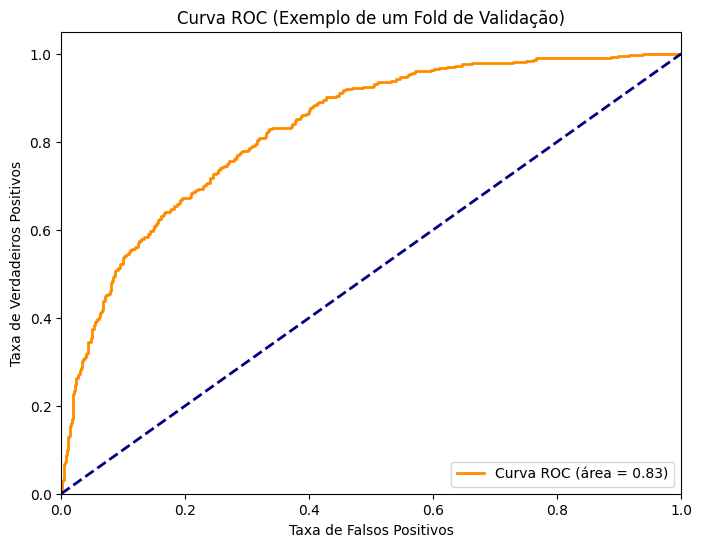

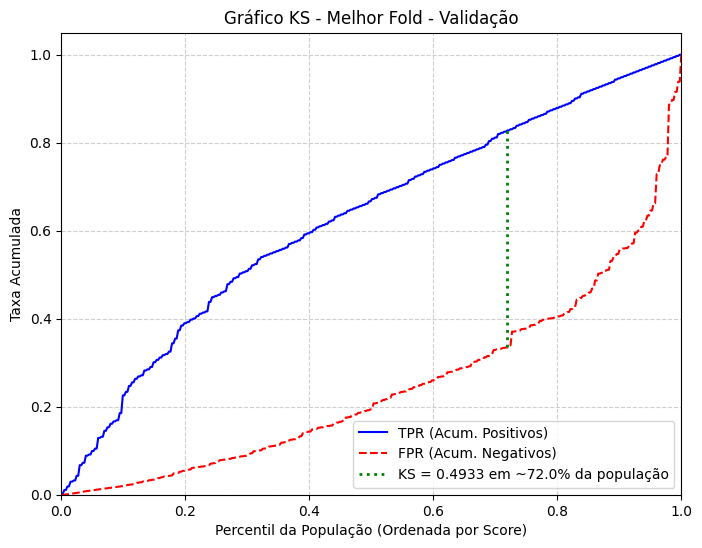

In [ ]:
def plot_ks_statistic(y_true, y_proba, title='Gráfico KS'):
    """
    Plota o gráfico KS baseado nos rótulos reais (y_true) e nas probabilidades previstas (y_proba).
    """
    # Garante que os inputs sejam arrays numpy
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    # Calcula o valor KS (diferença máxima entre TPR e FPR)
    ks_value = np.max(tpr - fpr)
    ks_index = np.argmax(tpr - fpr)

    # Cria o eixo X representando o percentil da população (aproximado)
    population_percentile = np.linspace(0, 1, len(tpr))
    x_ks_point = population_percentile[ks_index]

    plt.figure(figsize=(8, 6))
    plt.plot(population_percentile, tpr, label='TPR (Acum. Positivos)', color='blue')
    plt.plot(population_percentile, fpr, label='FPR (Acum. Negativos)', color='red', linestyle='--')
    plt.plot([x_ks_point, x_ks_point], [fpr[ks_index], tpr[ks_index]],
             color='green', linestyle=':', linewidth=2,
             label=f'KS = {ks_value:.4f} em ~{x_ks_point*100:.1f}% da população')
    plt.xlabel('Percentil da População (Ordenada por Score)')
    plt.ylabel('Taxa Acumulada')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()


# Exemplo de geração do gráfico ROC com dados de um fold de validação

def plot_roc_curve(y_true, y_proba, title='Curva ROC'):
    """
    Plota a curva ROC baseada nos rótulos reais e nas probabilidades previstas.
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(title)
    plt.legend(loc="lower right")


# Plot da curva ROC
plot_roc_curve(y_val, y_val_proba_Transformer,
               title='Curva ROC (Exemplo de um Fold de Validação)')

# Plot do gráfico KS
plot_ks_statistic(y_val, y_val_proba_Transformer,
                  title='Gráfico KS - Melhor Fold - Validação')

## KAN

In [28]:
from Kantf import KAN

model = KAN([
    {'in_features': 784, 'out_features': 64, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'},
    {'in_features': 64, 'out_features': 10, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'}
])

ModuleNotFoundError: No module named 'Kantf'

In [ ]:
from KAN.tabkannet.models import modulo
from KAN.tabkannet.models.modulo import TabMLPNet
from tabkanet.models import TabMLPNet
from tabkanet.tools import seed_everything, get_dataset, get_data_loader, train
from tabkanet.metrics import f1_score_macro


# Função para calcular os bins
def get_quantile_bins(x_cont, n_bins=4):
    feature_dim = x_cont.shape[1]
    bins = torch.zeros(feature_dim, n_bins + 1)
    for i in range(feature_dim):
        # Converta a coluna específica para tensor e depois calcule os quantis
        quantiles = torch.quantile(torch.tensor(x_cont.iloc[:, i].values, dtype=torch.float32), torch.linspace(0, 1, n_bins + 1))
        bins[i] = quantiles
    return bins




# Definir features
continuous_features = list(X_train.columns)
categorical_features = []
target_name = "Churn"
task = "classification"

# Criar datasets
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

dataset_train, dataset_val, dataset_test = get_dataset(
    df_train, df_val, df_test, target_name, task, categorical_features, continuous_features
)

dataloader_train, dataloader_val, dataloader_test = get_data_loader(
    dataset_train, dataset_val, dataset_test, train_batch_size=32, inference_batch_size=32
)

# Calcular bins
bins = get_quantile_bins(X_train)

# Definir o modelo
model = TabMLPNet(
    output_dim=1,  
    vocabulary={},
    num_continuous_features=len(continuous_features),
    embedding_dim=16, 
    mlp_hidden_dims=[32],
    activation="sigmoid",
    ffn_dropout_rate=0.1,
    nhead=8,
    num_layers=3,
    dim_feedforward=128,
    attn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
)

# Definir otimizador e loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-10, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss()

# Treinar o modelo
train_history, val_history, test_history = train(
    model, epochs=10, task=task, train_loader=dataloader_train, val_loader=dataloader_val,
    test_loader=dataloader_test, optimizer=optimizer, criterion=criterion,
    custom_metric=f1_score_macro, maximize=False, early_stopping_patience=5, gpu_num=0
)

ModuleNotFoundError: No module named 'KAN.tabkannet'

# 6. Análise dos melhores modelos encontrados